## <center>ANALYSIS OF PREDISPOSITION TO INDUSTRIAL SPECIALISATION IN MELBOURNE CBD</center>
<center>By: Tien Dung Pham (987950)</center>
<center style="color:red">COMP20008 - 2018 - SM2 - Project Phase 3A</center>

<span>Although Melbourne CBD is the robust trading centre of Victoria, it lacks a definitive area of industrial specialisation. A prime example is Wall Street in New York, which specialises in financial services business, or Madison Avenue which specialises in advertising industry. The specialisation in specific industry has brought positive investments and developments to other cities in the world.</span> 

<span>The investigation question is: **Is Melbourne CBD predisposed (have the capability) to form industrial specialisation areas?**</span>

<span>The datasets used are collected from the *Census of Land Use and Employment (CLUE)* reports from the City of Melbourne. Specifically, the predisposition is operationalised as both the number of businesses based on industry, the number of employees based on industry, the area blocks divided according to CLUE, and the population per area blocks. The timeframe of interest is 2017, but forecast into 2020 are also going to be predicted. </span> 

In [1]:
# Import basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import Machine Learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelBinarizer

# Import Linkage tools
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Visualisation of DTC
import pydotplus
from IPython.display import Image 

Both **employment_df** and **business_df** contains the following attributes:
+ Census year: Only 2017 for **business_df** but from 2002 - 2017 for **employment_df**
+ Block ID: The CLUE classifications for areas in the CBD
+ CLUE small area: The main suburb of the block
+ 20 Industry Categories: For **business_df**, it's the number of the registered businesses of that industry in the block, and for **employment_df**, it's the number of employments of that industry in the block
+ Total number

Each row in these dataframes represents a CLUE block. There are 603 blocks in 2017.

For **population_df**, it contains the following attributes:
+ Geography: Suburb names similar to 'CLUE small area'
+ Year: Year of forecast
+ Population: Forecasted figure for population of the suburb

In [2]:
employment_df =  pd.read_csv("Employment_by_block_by_CLUE_industry.csv")
population_df = pd.read_csv("Population_Forecasts_by_Small_Area.csv")
business_df = pd.read_csv("Count_of_business_establishments_per_industry_for_blocks_2017.csv")

print('Dimensions of dataset: employment_df')
print(employment_df.dtypes)
print()
print('Dimensions of dataset: population_df')
print(population_df.dtypes)
print()
print('Dimensions of dataset: business_df')
print(business_df.dtypes)
print()

Dimensions of dataset: employment_df
Census year                                     int64
Block ID                                        int64
CLUE small area                                object
Accommodation                                 float64
Admin and Support Services                    float64
Agriculture and Mining                        float64
Arts and Recreation Services                  float64
Business Services                             float64
Construction                                  float64
Education and Training                        float64
Electricity, Gas, Water and Waste Services    float64
Finance and Insurance                         float64
Food and Beverage Services                    float64
Health Care and Social Assistance             float64
Information Media and Telecommunications      float64
Manufacturing                                 float64
Other Services                                float64
Public Administration and Safety             

In [3]:
### DATA CLEANING ###

# Delete 'total' rows & subsetting datasets to Year=2017

employment17_df = employment_df[employment_df['Census year'] == 2017][:-1].reset_index(drop=True)
business17_df = business_df[:-1].reset_index(drop=True)
population17_df = population_df[population_df['Year'] == 2017][:-1].reset_index(drop=True)

print('Missing information in employment17_df')
print(employment17_df.isna().sum())
print()

# Impute empty total column with '0'
employment17_df['Total employment in block'] = employment17_df['Total employment in block'].fillna(0)

# Create numerical matrix of 20 Industry Categories
job = employment17_df.iloc[:,3:23]

# Fill missing information in each block by averaging the missing sum

fillna = {}
    
for i in range(job.shape[0]):
    if job.shape[1]-job.iloc[i,:].count() == 0:
        val = 0
    else:
        val = (employment17_df['Total employment in block'][i] - job.iloc[i,:].sum())/(job.shape[1]-job.iloc[i,:].count())
    fillna[i] = val

job = job.T.fillna(value=fillna).T

# Add a class attribute to each block, depending on the total number of employment in the block

def classify(x):
    if x  == 0:
        return 'Residential'
    return 'Industrial'

industrial_block = employment17_df['Total employment in block'].apply(lambda x: classify(x)).rename('Block type')

# Concatenating new df

employment17_df = pd.concat([employment17_df.iloc[:,:3],job,industrial_block],axis=1)
print('After cleaning missing values in employment17_df')
print(employment17_df.isna().sum())

employment17_df.head(2)

Missing information in employment17_df
Census year                                     0
Block ID                                        0
CLUE small area                                 0
Accommodation                                 129
Admin and Support Services                     99
Agriculture and Mining                         25
Arts and Recreation Services                  207
Business Services                              90
Construction                                  115
Education and Training                        121
Electricity, Gas, Water and Waste Services    124
Finance and Insurance                          66
Food and Beverage Services                    135
Health Care and Social Assistance             137
Information Media and Telecommunications      115
Manufacturing                                 114
Other Services                                154
Public Administration and Safety               90
Real Estate Services                           97
Rental and 

,Census year,Block ID,CLUE small area,Accommodation,Admin and Support Services,Agriculture and Mining,Arts and Recreation Services,Business Services,Construction,Education and Training,...,Information Media and Telecommunications,Manufacturing,Other Services,Public Administration and Safety,Real Estate Services,Rental and Hiring Services,Retail Trade,"Transport, Postal and Storage",Wholesale Trade,Block type
0,2017,1,Melbourne (CBD),0.0,94.0,0.0,81.5,81.5,0.0,0.0,...,0.0,0.0,3.0,0.0,81.5,81.5,81.5,81.5,0.0,Industrial
1,2017,2,Melbourne (CBD),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Residential


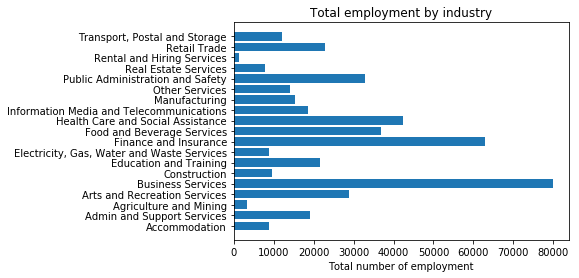

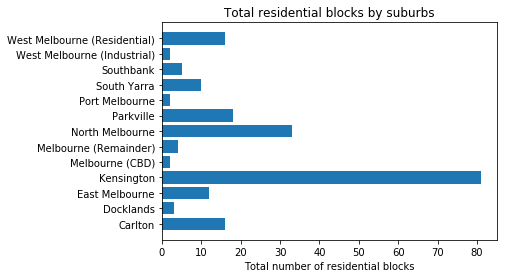

In [4]:
### BASIC VISUALISATION ###

# Subsetting cleaned dataset based on class
with_employ = employment17_df[employment17_df['Block type']=='Industrial']
non_employ = employment17_df[employment17_df['Block type']=='Residential']

# Bar chart for Industrial blocks
total_employ = with_employ.sum().iloc[3:22]
plt.barh(total_employ.keys(),total_employ.values)
plt.title('Total employment by industry')
plt.xlabel('Total number of employment')
plt.show()

# Bar chart for Residential blocks
group = non_employ.groupby(non_employ['CLUE small area'])
plt.barh(group.size().keys(),group.size().values)
plt.title('Total residential blocks by suburbs')
plt.xlabel('Total number of residential blocks')
plt.show()

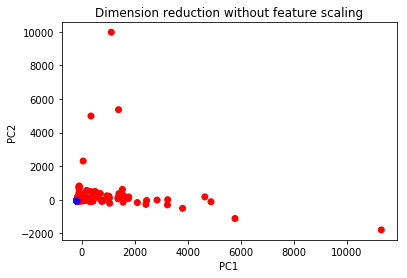

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Block ID,CLUE small area,Industry with highest employment,Maximum employment
16,24,Melbourne (CBD),Finance and Insurance,2139.0
19,27,Melbourne (CBD),Business Services,2116.0
23,32,Melbourne (CBD),Business Services,2610.0
25,34,Melbourne (CBD),Finance and Insurance,2995.0
28,37,Melbourne (CBD),Finance and Insurance,1841.0
39,52,Melbourne (CBD),Business Services,5548.0
40,53,Melbourne (CBD),Finance and Insurance,3871.0
65,85,Melbourne (CBD),Finance and Insurance,2278.0
536,1103,Docklands,Finance and Insurance,6604.0
538,1105,Docklands,Finance and Insurance,3650.0


In [49]:
### PCA & OUTLIER ANALYSIS ###

# Create matrix X and Vector y
X = employment17_df.iloc[:,3:22].values
y = employment17_df['Block type'].values

# Create color map from Vector y
color = []
for i in y:
    if i == 'Industrial':
        color.append('r')
    elif i == 'Residential':
        color.append('b')

# Instantiate PCA
pca = PCA(n_components=2)

# Plot without scaling
X_reduced = pca.fit_transform(X)
plt.figure(1)
plt.title('Dimension reduction without feature scaling')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(X_reduced[:, 0], X_reduced[:,1], c=color)
plt.show()

# Outlier from graph
outliers = np.argwhere(X_reduced[:,0]>2000).ravel().tolist()+(np.argwhere(X_reduced[:,1]>2000).ravel().tolist())
outlier_df = employment17_df.iloc[outliers,:]
outlier_df['Industry with highest employment'] = outlier_df.iloc[:,3:-1].idxmax(axis=1)
outlier_df.assign(Maximum_employment=np.nan)

outlier_df['Maximum employment'] = outlier_df.apply(lambda x: x[x['Industry with highest employment']], axis=1)
outlier_df[['Block ID','CLUE small area','Industry with highest employment','Maximum employment']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


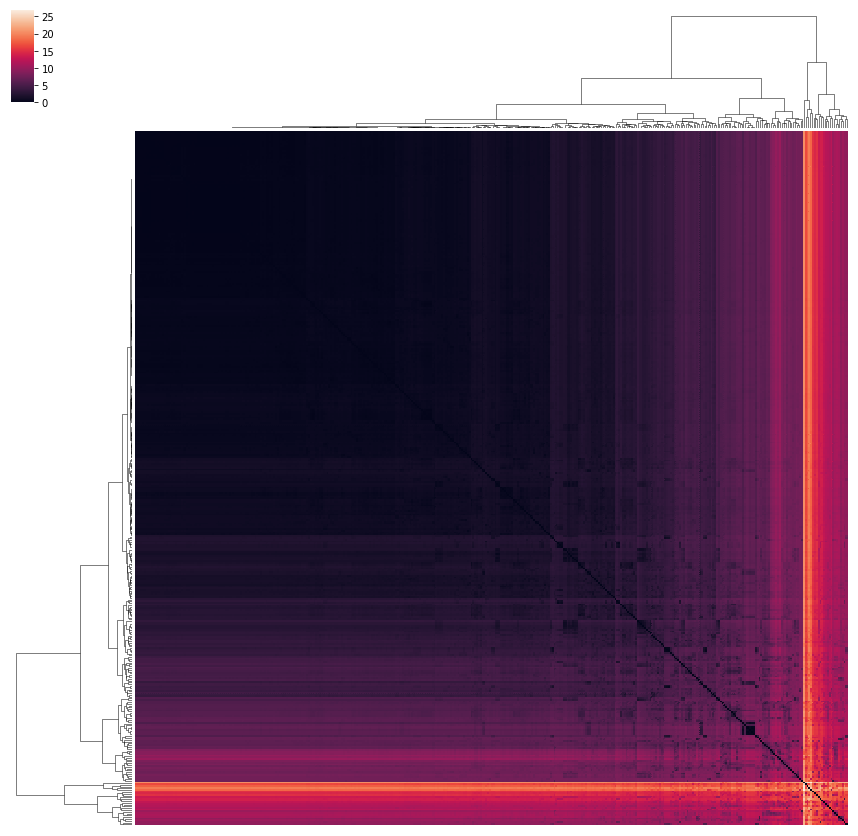

In [6]:
### HIERARCHICAL CLUSTERING OF INDUSTRIAL BLOCKS ###

warnings.filterwarnings("once")

# New matrix without outliers
clean_df = employment17_df.drop(outliers).reset_index(drop=True)
clean_industrial = clean_df[clean_df['Block type']=='Industrial']
X = clean_industrial.iloc[:,3:22].values

# Instantiate scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Plot complete linkage heatmap with dendogram
dissim_mat = squareform(pdist(X_scaled, metric='euclidean'))
complete_linkage = sns.clustermap(dissim_mat, method='complete', 
                                  xticklabels=False, yticklabels=False, figsize=(15,15))

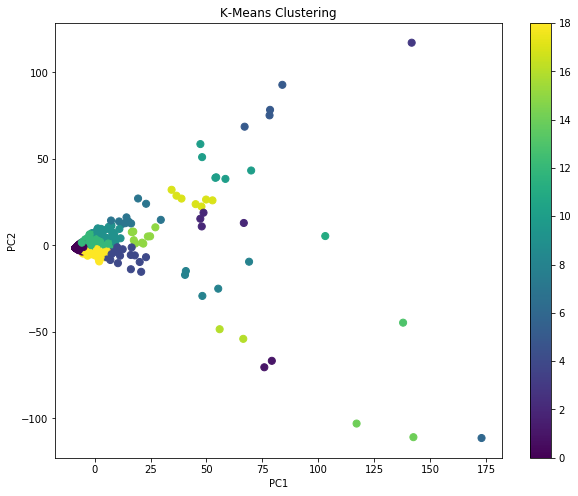

In [7]:
### K MEAN CLUSTERING FOR BUSINESSES DATASET ###

# Create scaled matrix
business_df = business_df[:-1].reset_index(drop=True)
X2 = business_df.iloc[:,3:22]
X2_reduced = pca.fit_transform(X2)
X2_scaled = scaler.fit_transform(X2_reduced)

# K-means Clustering Visualisation
# Adopted from https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

# K=19 assuming that each cluster is one of the 19 industries
clust_labels, cent = doKmeans(X2_scaled, 19)
kmeans = pd.DataFrame(clust_labels)

# Plot the clusters obtained using k means
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X2_reduced[:,0],X2_reduced[:,1],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(scatter)

plt.show()

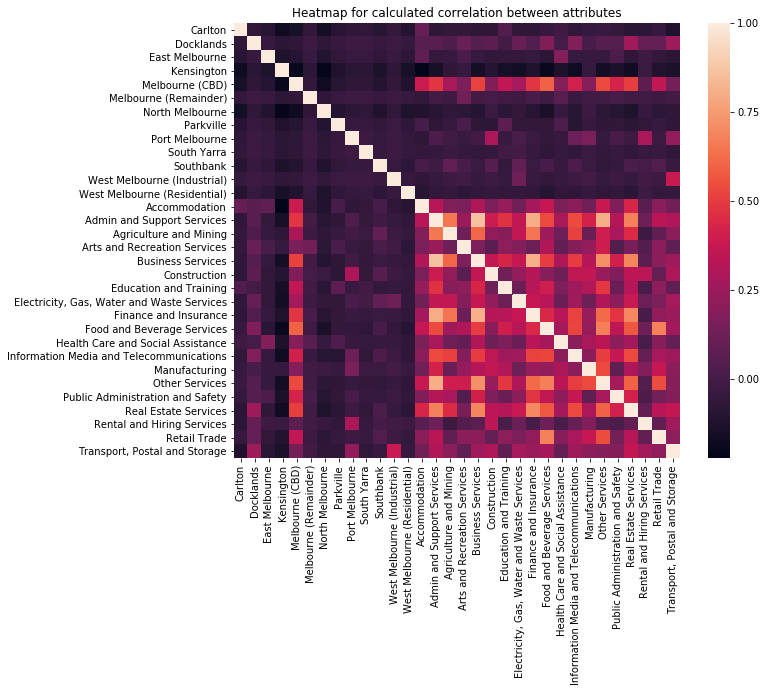

In [8]:
### CORRELATION ANALYSIS BETWEEN AREA & BUSINESS TYPE AND BETWEEN BUSINESS TYPES ###

# Binarise the 'CLUE small area' column into 13 binary columns
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(business_df['CLUE small area'])
encoded = pd.concat([pd.DataFrame(lb_results, columns=lb_style.classes_),X2],axis=1)

# Instantiate figure
plt.figure(figsize=(10,8))

# Calculate correlation matrix
corr_df = encoded.corr()

# Plot heatmap
plt.title('Heatmap for calculated correlation between attributes')
sns.heatmap(corr_df,xticklabels=corr_df.columns.values, yticklabels=corr_df.columns.values)

# Show plot
plt.show()

In [9]:
### DT CLASSIFIER  ###

# Create Test set of average values of each suburb
lst = []
for k, group in employment17_df.groupby('CLUE small area'):
    i = group.mean()[2:22]
    i['Area']=k
    lst.append(i)

test = pd.DataFrame(lst)

X_test = test.iloc[:,:-1].values
y_test = test['Area'].values

# Re-create Train set
X_train = employment17_df.iloc[:,3:23].values
y_train = employment17_df['CLUE small area'].values

# Train & Predict
dtc = DecisionTreeClassifier("entropy", max_depth=8)
dtc.fit(X_train, y_train)
train_pred = dtc.predict(X_train)
test_pred = dtc.predict(X_test)

# Accuracy SCore
train_acc = accuracy_score(y_true=y_train, y_pred=train_pred)
test_acc = accuracy_score(y_true=y_test, y_pred=test_pred)

print('Train accuracy: ' + str(train_acc))
print('Test accuracy: ' + str(test_acc))

Train accuracy: 0.6049586776859505
Test accuracy: 0.5384615384615384


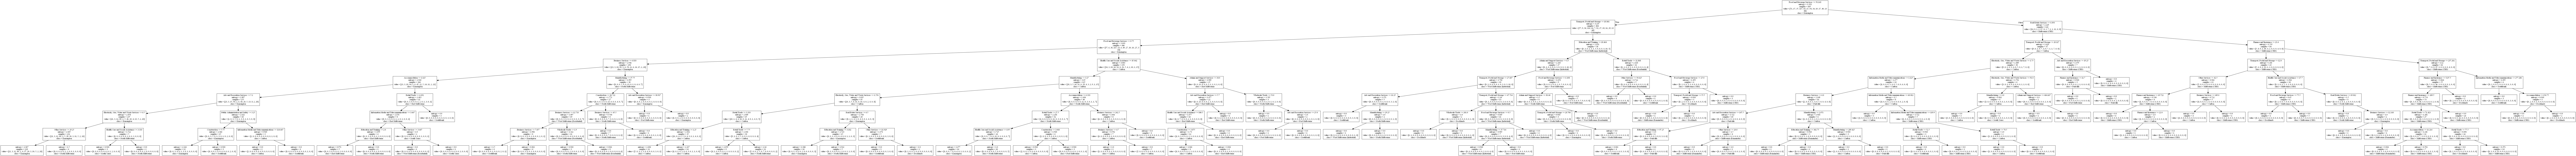

In [10]:
### VISUALISE DTC ###

# Create DOT data
dot_data = export_graphviz(dtc, out_file=None, feature_names=test.iloc[:,:-1].columns, class_names=test['Area'].values)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [11]:
### DATA LINKAGE & CORRELATION ###

# Data linkage on suburb names
residential_by_block = pd.DataFrame(pd.Series(non_employ.groupby('CLUE small area').size(),name='No of residential blocks')).reset_index()
population17_df = population_df[population_df['Year']==2017]
merged = pd.merge(residential_by_block,population17_df,right_on='Geography',left_on='CLUE small area').drop(['Year','Geography'],axis=1)

# Pearson Correlation 
print('Pearson correlation between number of residential blocks and population size')
print(np.corrcoef(merged['No of residential blocks'], merged['Population'])[0][1])
print()

# Add average column
merged['Population per residential block'] = merged['Population']/merged['No of residential blocks']
merged = merged.sort_values(by='Population per residential block', ascending=False).reset_index(drop=True)

# Drop outliers
merged_clean = merged.drop([0, 11, 12])

print('Pearson correlation without outliers')
print(np.corrcoef(merged_clean['No of residential blocks'], merged_clean['Population'])[0][1])

# Display sorted dataframe
merged

Pearson correlation between number of residential blocks and population size
0.014729423024402747

Pearson correlation without outliers
0.1267451360896581


,CLUE small area,No of residential blocks,Population,Population per residential block
0,Melbourne (CBD),2,42589,21294.500000
1,Southbank,5,21065,4213.000000
2,Docklands,3,12458,4152.666667
3,Carlton,16,20776,1298.500000
4,North Melbourne,33,16985,514.696970
5,Melbourne (Remainder),4,1989,497.250000
6,South Yarra,10,4654,465.400000
7,East Melbourne,12,5490,457.500000
8,Parkville,18,7929,440.500000
9,West Melbourne (Residential),16,5564,347.750000


Coefficient of Determination
0.6779724348188343


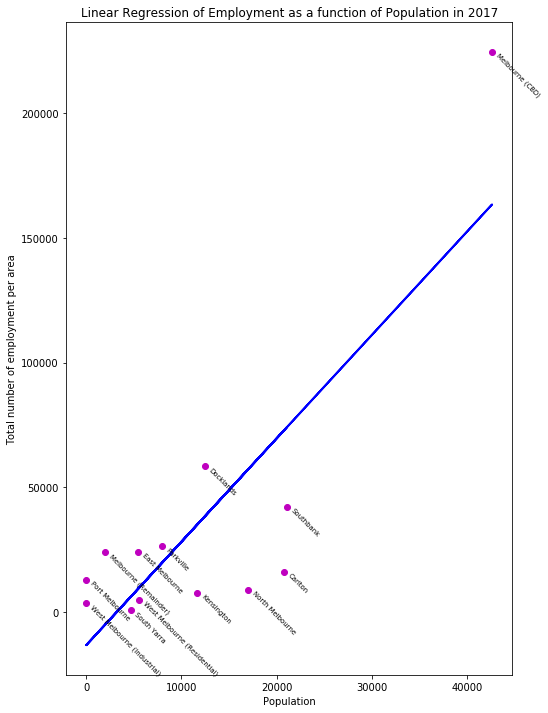

,CLUE small area,Total employment,Predicted employment 2018,Predicted employment 2019,Predicted employment 2020
0,Carlton,16073.0,169588.999725,179353.977025,198817.587830
1,Docklands,58489.0,74746.398544,77843.824465,80825.148745
2,East Melbourne,24183.0,41155.705930,46002.949439,52682.940280
3,Kensington,7894.0,9795.823417,9994.854801,10633.413826
4,Melbourne (CBD),224395.0,35980.889934,37336.791241,38580.737394
5,Melbourne (Remainder),24023.0,-4534.436264,-3684.406393,-2469.485651
6,North Melbourne,8897.0,58558.512608,64575.065501,70235.020497
7,Parkville,26394.0,19880.080229,20390.098152,21401.841023
8,Port Melbourne,12992.0,-13175.715540,-13175.715540,-13175.715540
9,South Yarra,777.0,77566.009824,80364.888668,83640.613537


In [12]:
### LINEAR REGRESSION & PREDICTION OF TOTAL EMPLOYMENT & POPULATION FOR 3 YEARS ###

# Data linkage between Employment and Forecast Population
total_employment = employment17_df.groupby('CLUE small area').sum().drop(['Census year','Block ID'],axis=1).reset_index()
total_employment['Total employment']=total_employment.iloc[:,1:].T.sum()
population17_df = population_df[population_df['Year']==2017]
merged = pd.merge(total_employment,population17_df,right_on='Geography',left_on='CLUE small area').drop(['Year','Geography'],axis=1)

# Create train set (Test on the same train set)
X_train = merged['Population'].values.reshape(-1, 1)
y_train = merged['Total employment'].values.reshape(-1, 1)

# Regression & Prediction

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)

# Coefficient of Determination
print('Coefficient of Determination')
print(r2_score(y_train, y_pred))

# Plot outputs
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, color='m')
ax.plot(X_train, y_pred, color='blue', linewidth=2)
ax.set_title('Linear Regression of Employment as a function of Population in 2017')
ax.set(xlabel='Population', ylabel='Total number of employment per area')
labels = merged['CLUE small area'].values
for i, txt in enumerate(labels):
    ax.annotate(txt, (X_train[i], y_train[i]),size='x-small', rotation=-45, xytext=(3, -5), textcoords='offset points')
plt.show()

# Forecast into 2020
lst = []
for i in [2018,2019,2020]:
    pred = reg.predict(population_df[population_df['Year']==i]['Population'].values.reshape(-1,1))
    lst.append(pd.Series(pred.ravel(), name='Predicted employment ' + str(i)))

# Show forecast df
pd.merge(merged.loc[:,['CLUE small area','Total employment']], pd.DataFrame(lst).T, right_index=True, left_index=True)

## <center>CONCLUSION</center>
Analysis on the current Employment & Population datasets of City of Melbourne reveals that there is little evidence for a predisposition for industrial specialisation in Melbourne CBD. Most employments and industries are highly concentrated in the CBD area, turning the most important area of the dataset to an outlier which challenges the interpretation. However, the analysis reveals a potential for Dockland to become the next Central Business District of Melbourne; and a strong focus on Business & Professional Services for City of Melbourne.